In [1]:
# ===================================================
# CELL 1: SETUP AND IMPORTS
# ===================================================
import os
import sys
import logging
import warnings
import gc
import hashlib
import json
from typing import Tuple, List, Optional, Dict, Any
from pathlib import Path
from dataclasses import dataclass, field
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configure environment
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("="*70)
print("ENVIRONMENT VERIFICATION")
print("="*70)
print(f"Python:         {sys.version.split()[0]}")
print(f"TensorFlow:     {tf.__version__}")
print(f"NumPy:          {np.__version__}")
print(f"OpenCV:         {cv2.__version__}")
print("-"*70)

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled: {len(gpus)} GPU(s)")
        
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        print(f"   Device: {gpu_details.get('device_name', 'Unknown')}")
        print(f"   Compute: {gpu_details.get('compute_capability', 'Unknown')}")
        
        # Mixed precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("✅ Mixed precision enabled (float16)")
    except Exception as e:
        logger.warning(f"GPU setup: {e}")
else:
    print("⚠️ No GPU detected - using CPU")

# Check OpenCV saliency
if hasattr(cv2, 'saliency'):
    print("✅ OpenCV saliency module available")
else:
    print("⚠️ OpenCV saliency module not found")

print("="*70 + "\n")


ENVIRONMENT VERIFICATION
Python:         3.9.23
TensorFlow:     2.10.1
NumPy:          1.23.5
OpenCV:         4.8.1
----------------------------------------------------------------------
✅ GPU memory growth enabled: 1 GPU(s)
   Device: NVIDIA GeForce RTX 3050 Laptop GPU
   Compute: (8, 6)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


[INFO] Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


✅ Mixed precision enabled (float16)
✅ OpenCV saliency module available



In [2]:
# ===================================================
# CELL 2: CONFIGURATION
# ===================================================
@dataclass
class Config:
    """Configuration - EDIT THE PATH BELOW"""
    # ✏️ CHANGE THIS TO YOUR DATASET PATH
    raw_root: Path = Path(r"D:\monument_dataset\Indian-monuments")
    out_root: Path = Path(r"D:\monument_dataset\ivp_dataset_processed")
    
    # MEMORY OPTIMIZATION: Maximum image dimension
    max_image_dimension: int = 1024  # REDUCED from 2048 for 16GB RAM
    
    @property
    def saliency_output_path(self) -> Path:
        return self.out_root.parent / "saliency_crops"
    
    @property
    def models_dir(self) -> Path:
        return self.out_root.parent / "models"
    
    @property
    def logs_dir(self) -> Path:
        return self.out_root.parent / "logs"
    
    @property
    def results_dir(self) -> Path:
        return self.out_root.parent / "results"
    
    @property
    def visualizations_dir(self) -> Path:
        return self.out_root.parent / "visualizations"
    
    min_crop_dimension: int = 256
    jpeg_quality: int = 90  # Reduced from 95 for smaller files
    
    def validate_paths(self) -> None:
        if not self.raw_root.exists():
            raise FileNotFoundError(f"Dataset not found: {self.raw_root}")
        if not (self.raw_root / "train").exists() or not (self.raw_root / "test").exists():
            raise FileNotFoundError(f"'train' and 'test' folders required in {self.raw_root}")
    
    def create_directories(self) -> None:
        for dir_path in [self.out_root, self.saliency_output_path, self.models_dir, 
                         self.logs_dir, self.results_dir, self.visualizations_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
        logger.info("✅ All output directories ready")

# Initialize config
config = Config()
config.validate_paths()
config.create_directories()

print(f"📁 Configuration:")
print(f"   Dataset:     {config.raw_root}")
print(f"   Processed:   {config.out_root}")
print(f"   Max img size: {config.max_image_dimension}px (memory optimized)")
print(f"   Models:      {config.models_dir}")
print(f"   Results:     {config.results_dir}\n")


[INFO] ✅ All output directories ready


📁 Configuration:
   Dataset:     D:\monument_dataset\Indian-monuments
   Processed:   D:\monument_dataset\ivp_dataset_processed
   Max img size: 1024px (memory optimized)
   Models:      D:\monument_dataset\models
   Results:     D:\monument_dataset\results



In [1]:
# ===================================================
# CELL 3: DATA CLEANING (MEMORY OPTIMIZED)
# ===================================================
class DataCleaner:
    """Clean and organize dataset with memory optimization"""
    
    def __init__(self, config: Config):
        self.config = config
        self.stats = defaultdict(lambda: defaultdict(int))
        self.supported_formats = ('.jpg', '.jpeg', '.png', '.jfif', '.webp', '.bmp', '.tiff')
    
    def clean_single_image(self, src_path: Path, dest_path: Path) -> Tuple[bool, str]:
        try:
            if src_path.stat().st_size < 1024:
                return False, "File too small"
            
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # MEMORY OPTIMIZATION: Resize large images immediately
                if img.width > self.config.max_image_dimension or img.height > self.config.max_image_dimension:
                    if img.width > img.height:
                        new_w = self.config.max_image_dimension
                        new_h = int(img.height * (self.config.max_image_dimension / img.width))
                    else:
                        new_h = self.config.max_image_dimension
                        new_w = int(img.width * (self.config.max_image_dimension / img.height))
                    img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
                
                if img.width < 100 or img.height < 100:
                    return False, "Image dimensions too small"
                
                dest_path.parent.mkdir(parents=True, exist_ok=True)
                img.save(dest_path, "JPEG", quality=self.config.jpeg_quality)
                
                return True, "Success"
        except Exception as e:
            return False, str(e)[:50]
    
    def clean_and_organize_dataset(self) -> Dict[str, Any]:
        logger.info("🧹 Starting Data Cleaning (with memory optimization)")
        results = {'processed': 0, 'failed': 0, 'skipped': 0, 'errors': [], 'resized': 0}
        
        for split in ['train', 'test']:
            split_path = self.config.raw_root / split
            if not split_path.exists():
                continue
            
            logger.info(f"\n✨ Processing '{split}' split...")
            
            # NEW: Iterate through style folders, then monument folders
            for style_dir in split_path.iterdir():
                if not style_dir.is_dir():
                    continue
                
                style_name = style_dir.name
                
                for monument_dir in style_dir.iterdir():
                    if not monument_dir.is_dir():
                        continue
                    
                    monument_name = monument_dir.name
                    image_files = [p for ext in self.supported_formats 
                                  for p in monument_dir.glob(f"*{ext}")]
                    
                    if len(image_files) == 0:
                        continue
                    
                    logger.info(f"   Processing {style_name}/{monument_name}: {len(image_files)} images")
                    
                    with ThreadPoolExecutor() as executor:
                        futures = {}
                        for src_path in image_files:
                            file_hash = hashlib.md5(str(src_path).encode()).hexdigest()[:8]
                            dest_name = f"{src_path.stem}_{file_hash}.jpg"
                            # NEW: Maintain style/monument hierarchy
                            dest_path = self.config.out_root / split / style_name / monument_name / dest_name
                            
                            if dest_path.exists():
                                results['skipped'] += 1
                                continue
                            
                            future = executor.submit(self.clean_single_image, src_path, dest_path)
                            futures[future] = (src_path, style_name)
                        
                        for future in tqdm(as_completed(futures), total=len(futures), 
                                          desc=f"  {style_name}/{monument_name}", unit="img", leave=False):
                            src_path, class_name = futures[future]
                            success, message = future.result()
                            
                            if success:
                                results['processed'] += 1
                                self.stats[split][style_name] += 1
                            else:
                                results['failed'] += 1
                                results['errors'].append({'file': str(src_path), 'error': message})
        
        self._print_summary(results)
        return results
    
    def _print_summary(self, results: Dict[str, Any]) -> None:
        print("\n" + "="*50)
        print("🎉 DATA CLEANING COMPLETE")
        print("="*50)
        print(f"✅ Successfully processed: {results['processed']} images")
        print(f"⏭️  Skipped (existing):     {results['skipped']} images")
        print(f"⚠️  Failed:                {results['failed']} images")
        
        if results['errors'] and len(results['errors']) > 0:
            print(f"\n❌ First 5 errors:")
            for error in results['errors'][:5]:
                print(f"   - {Path(error['file']).name}: {error['error']}")
        
        print("\n📊 Class Distribution (Architectural Styles):")
        for split, classes in self.stats.items():
            print(f"\n{split.upper()}:")
            for class_name, count in sorted(classes.items()):
                print(f"   - {class_name}: {count} images")
        print("="*50 + "\n")

print("Running data cleaning...")
cleaner = DataCleaner(config)
cleaning_results = cleaner.clean_and_organize_dataset()


NameError: name 'Config' is not defined

In [8]:
# ===================================================
# CELL 4: SALIENCY PROCESSING (MEMORY OPTIMIZED)
# ===================================================
class SaliencyProcessor:
    """Saliency detection with memory optimization"""
    
    def __init__(self, config: Config):
        self.config = config
        self.min_crop_dimension = config.min_crop_dimension
    
    def get_saliency_crops(self, img: np.ndarray) -> List[Tuple[int, int, int, int]]:
        try:
            saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
            success, saliency_map = saliency.computeSaliency(img)
            if not success:
                return []
            
            saliency_uint8 = (saliency_map * 255).astype(np.uint8)
            _, thresh = cv2.threshold(saliency_uint8, 0, 255, 
                                     cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, 
                                          cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                return []
            
            boxes = [cv2.boundingRect(c) for c in contours]
            boxes.sort(key=lambda b: b[2] * b[3], reverse=True)
            return [(x, y, x + w, y + h) for x, y, w, h in boxes[:3]]
        except Exception as e:
            logger.warning(f"Saliency detection failed: {e}")
            return []
    
    def get_fallback_crop(self, img: np.ndarray) -> List[Tuple[int, int, int, int]]:
        h, w = img.shape[:2]
        return [(int(w*0.05), int(h*0.05), int(w*0.95), int(h*0.95))]
    
    def process_dataset(self) -> Dict[str, Any]:
        logger.info("🎯 Starting Saliency Cropping (memory optimized)")
        stats = defaultdict(int)
        
        for split in ['train', 'test']:
            split_src = self.config.out_root / split
            split_dst = self.config.saliency_output_path / split
            if not split_src.exists():
                continue
            
            logger.info(f"\n🔍 Processing '{split}' split for saliency...")
            
            # NEW: Iterate through style folders, then monument folders
            for style_dir in split_src.iterdir():
                if not style_dir.is_dir():
                    continue
                
                style_name = style_dir.name
                
                for monument_dir in style_dir.iterdir():
                    if not monument_dir.is_dir():
                        continue
                    
                    monument_name = monument_dir.name
                    image_files = list(monument_dir.glob("*.jpg"))
                    
                    if len(image_files) == 0:
                        continue
                    
                    logger.info(f"   Processing {style_name}/{monument_name}: {len(image_files)} images")
                    
                    for img_path in tqdm(image_files, desc=f"  {style_name}/{monument_name}", leave=False):
                        try:
                            img = cv2.imread(str(img_path))
                            if img is None:
                                continue
                            
                            # MEMORY OPTIMIZATION: Ensure image isn't too large
                            h, w = img.shape[:2]
                            if w > self.config.max_image_dimension or h > self.config.max_image_dimension:
                                scale = self.config.max_image_dimension / max(w, h)
                                new_w, new_h = int(w * scale), int(h * scale)
                                img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
                            
                            saliency_boxes = self.get_saliency_crops(img)
                            valid_boxes = [b for b in saliency_boxes 
                                          if (b[2]-b[0]) >= self.min_crop_dimension 
                                          and (b[3]-b[1]) >= self.min_crop_dimension]
                            
                            final_boxes = valid_boxes if valid_boxes else self.get_fallback_crop(img)
                            stats['fallback_used' if not valid_boxes else 'saliency_success'] += 1
                            
                            # NEW: Maintain style/monument hierarchy
                            dst_dir = split_dst / style_name / monument_name
                            dst_dir.mkdir(parents=True, exist_ok=True)
                            
                            for i, (x1, y1, x2, y2) in enumerate(final_boxes):
                                crop = img[y1:y2, x1:x2]
                                if crop.size == 0:
                                    continue
                                out_path = dst_dir / f"{img_path.stem}_sal_{i}.jpg"
                                cv2.imwrite(str(out_path), crop, [cv2.IMWRITE_JPEG_QUALITY, self.config.jpeg_quality])
                                stats['total_crops'] += 1
                            
                            stats['total_processed'] += 1
                        except Exception as e:
                            logger.error(f"Error processing {img_path}: {e}")
                            stats['errors'] += 1
        
        self._print_summary(stats)
        return stats
    
    def _print_summary(self, stats: Dict[str, Any]) -> None:
        print("\n" + "="*50)
        print("🎯 SALIENCY CROPPING COMPLETE")
        print("="*50)
        total = stats.get('total_processed', 0)
        if total > 0:
            success_rate = (stats.get('saliency_success', 0) / total) * 100
            print(f"✅ Total images processed: {total}")
            print(f"🎯 Saliency detected:      {stats.get('saliency_success', 0)} ({success_rate:.1f}%)")
            print(f"🔄 Fallback used:          {stats.get('fallback_used', 0)}")
            print(f"📸 Total crops:            {stats.get('total_crops', 0)}")
        if stats.get('errors'):
            print(f"⚠️  Errors: {stats['errors']}")
        print("="*50 + "\n")

print("Running saliency processing...")
saliency_processor = SaliencyProcessor(config)
saliency_stats = saliency_processor.process_dataset()


[INFO] 🎯 Starting Saliency Cropping (memory optimized)
[INFO] 
🔍 Processing 'train' split for saliency...
[INFO]    Processing Ancient_Caves/Ajanta Caves: 258 images


Running saliency processing...


[INFO]    Processing Ancient_Caves/Ellora Caves: 110 images                                                            
[INFO]    Processing Buddhist/Buddhist_Monuments: 112 images                                                           
[INFO]    Processing Colonial/basilica_of_bom_jesus: 100 images                                                        
[INFO]    Processing Colonial/Gateway of India: 202 images                                                             
[INFO]    Processing Colonial/India_gate: 173 images                                                                   
[INFO]    Processing Colonial/victoria memorial: 200 images                                                            
[INFO]    Processing Delhi_Sultanate/alai_darwaza: 70 images                                                           
[INFO]    Processing Delhi_Sultanate/alai_minar: 140 images                                                            
[INFO]    Processing Delhi_Sultanate/jam


🎯 SALIENCY CROPPING COMPLETE
✅ Total images processed: 5579
🎯 Saliency detected:      2808 (50.3%)
🔄 Fallback used:          2771
📸 Total crops:            6002



In [2]:
# ===================================================
# CELL 5: EXPERIMENT CONFIGURATION
# ===================================================
@dataclass
class ExperimentConfig:
    """Experiment configuration (memory optimized)"""
    model_name: str = 'inception_v3'
    dataset_type: str = 'original'
    batch_size: int = 16  # REDUCED default for 16GB RAM
    initial_epochs: int = 8
    fine_tune_epochs: int = 12
    initial_lr: float = 0.001
    fine_tune_lr: float = 0.00001
    augmentation_strength: str = 'medium'
    use_mixup: bool = True
    mixup_alpha: float = 0.2
    
    experiment_name: str = field(init=False)
    model_save_path: Path = field(init=False)
    log_dir: Path = field(init=False)
    
    def __post_init__(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.experiment_name = f"{self.model_name}_{self.dataset_type}_{timestamp}"
        self.model_save_path = config.models_dir / f"{self.experiment_name}.keras"
        self.log_dir = config.logs_dir / self.experiment_name
        self.log_dir.mkdir(parents=True, exist_ok=True)
    
    @property
    def image_size(self) -> Tuple[int, int]:
        return (299, 299) if 'inception' in self.model_name else (224, 224)
    
    def save(self) -> None:
        config_path = self.log_dir / "config.json"
        data_to_save = {k: str(v) if isinstance(v, Path) else v 
                       for k, v in self.__dict__.items()}
        with open(config_path, 'w') as f:
            json.dump(data_to_save, f, indent=2)
        logger.info(f"💾 Config saved: {config_path}")

print("✅ Experiment configuration class defined")

NameError: name 'dataclass' is not defined

In [10]:
# ===================================================
# CELL 6: DATA PIPELINE (MEMORY OPTIMIZED)
# ===================================================
class DataPipeline:
    """Data pipeline with aggressive memory optimization"""
    
    def __init__(self, config: Config, exp_config: ExperimentConfig):
        self.config = config
        self.exp_config = exp_config
        self.autotune = tf.data.AUTOTUNE
        
        # NEW: Get architectural styles as classes (not individual monuments)
        self.class_names = sorted(['Ancient_Caves', 'Buddhist', 'Colonial', 
                                   'Delhi_Sultanate', 'Dravidian', 'Mughal', 
                                   'Nagara', 'Rajput'])
        self.num_classes = len(self.class_names)
        logger.info(f"Pipeline initialized: {self.num_classes} architectural styles")
        logger.info(f"Classes: {', '.join(self.class_names)}")
    
    def _load_directory_with_style_labels(self, directory: Path, shuffle: bool) -> tf.data.Dataset:
        """Load images and assign labels based on architectural style (grandparent folder)"""
        
        image_paths = []
        labels = []
        
        # Collect all images with their architectural style labels
        for style_dir in directory.iterdir():
            if not style_dir.is_dir():
                continue
            
            style_name = style_dir.name
            if style_name not in self.class_names:
                logger.warning(f"Unknown style folder: {style_name}")
                continue
            
            style_label = self.class_names.index(style_name)
            
            # Get all images from all monument subfolders
            for monument_dir in style_dir.iterdir():
                if not monument_dir.is_dir():
                    continue
                
                for img_path in monument_dir.glob('*.jpg'):
                    image_paths.append(str(img_path))
                    labels.append(style_label)
        
        logger.info(f"Loaded {len(image_paths)} images from {directory.name}")
        
        if len(image_paths) == 0:
            raise ValueError(f"No images found in {directory}")
        
        # Create TensorFlow dataset
        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
        label_ds = tf.data.Dataset.from_tensor_slices(labels)
        
        # Load and preprocess images
        def load_image(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.exp_config.image_size)
            return img, label
        
        dataset = tf.data.Dataset.zip((path_ds, label_ds))
        dataset = dataset.map(load_image, num_parallel_calls=self.autotune)
        
        # Convert labels to one-hot
        dataset = dataset.map(
            lambda x, y: (x, tf.one_hot(y, self.num_classes)),
            num_parallel_calls=self.autotune
        )
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=min(len(image_paths), 10000), seed=42)
        
        dataset = dataset.batch(self.exp_config.batch_size)
        
        return dataset
    
    def mixup(self, images: tf.Tensor, labels: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        alpha = self.exp_config.mixup_alpha
        batch_size = tf.shape(images)[0]
        lambda_param = tfp.distributions.Beta(alpha, alpha).sample(batch_size)
        lambda_x = tf.reshape(lambda_param, (batch_size, 1, 1, 1))
        lambda_y = tf.reshape(lambda_param, (batch_size, 1))
        indices = tf.random.shuffle(tf.range(batch_size))
        mixed_images = lambda_x * images + (1.0 - lambda_x) * tf.gather(images, indices)
        mixed_labels = lambda_y * labels + (1.0 - lambda_y) * tf.gather(labels, indices)
        return mixed_images, mixed_labels
    
    def load_datasets(self) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        logger.info(f"📁 Loading datasets: '{self.exp_config.dataset_type}'")
        
        if self.exp_config.dataset_type == 'original':
            train_ds = self._load_directory_with_style_labels(self.config.out_root / 'train', True)
            test_ds = self._load_directory_with_style_labels(self.config.out_root / 'test', False)
        elif self.exp_config.dataset_type == 'saliency':
            train_ds = self._load_directory_with_style_labels(self.config.saliency_output_path / 'train', True)
            test_ds = self._load_directory_with_style_labels(self.config.saliency_output_path / 'test', False)
        else:  # combined
            train_orig = self._load_directory_with_style_labels(self.config.out_root / 'train', True)
            train_sal = self._load_directory_with_style_labels(self.config.saliency_output_path / 'train', True)
            train_ds = train_orig.concatenate(train_sal).shuffle(10000, seed=42)
            test_ds = self._load_directory_with_style_labels(self.config.out_root / 'test', False)
        
        # Split validation
        val_size = tf.data.experimental.cardinality(train_ds) // 5
        val_ds = train_ds.take(val_size)
        train_ds = train_ds.skip(val_size)
        
        # MEMORY OPTIMIZATION: Optimize datasets with reduced buffer
        train_ds = self._optimize_dataset(train_ds, training=True)
        val_ds = self._optimize_dataset(val_ds, training=False)
        test_ds = self._optimize_dataset(test_ds, training=False)
        
        self._log_dataset_info(train_ds, val_ds, test_ds)
        return train_ds, val_ds, test_ds
    
    def _optimize_dataset(self, dataset: tf.data.Dataset, training: bool) -> tf.data.Dataset:
        # MEMORY OPTIMIZATION: Use smaller cache and prefetch
        dataset = dataset.cache()
        if training and self.exp_config.use_mixup:
            dataset = dataset.map(self.mixup, num_parallel_calls=self.autotune)
        return dataset.prefetch(buffer_size=2)  # REDUCED from AUTOTUNE
    
    def _log_dataset_info(self, train_ds, val_ds, test_ds):
        print("\n" + "="*50)
        print("📊 DATASET STATISTICS")
        print("="*50)
        print(f"Classes: {self.num_classes} architectural styles")
        print(f"Class names: {', '.join(self.class_names)}")
        for name, ds in [("Training", train_ds), ("Validation", val_ds), ("Test", test_ds)]:
            batches = tf.data.experimental.cardinality(ds).numpy()
            images = batches * self.exp_config.batch_size if batches > 0 else 0
            print(f"{name:12s}: {batches:4d} batches (~{images:5d} images)")
        print("="*50 + "\n")

print("✅ DataPipeline class defined")


✅ DataPipeline class defined


In [3]:
# ===================================================
# CELL 7: MODEL FACTORY
# ===================================================
class ModelFactory:
    """Model factory"""
    
    @staticmethod
    def get_base_model(model_name: str, input_shape: Tuple[int, int, int]):
        models_map = {
            'inception_v3': (
                tf.keras.applications.InceptionV3,
                tf.keras.applications.inception_v3.preprocess_input
            ),
            'inception_resnet_v2': (
                tf.keras.applications.InceptionResNetV2,
                tf.keras.applications.inception_resnet_v2.preprocess_input
            ),
        }
        
        if model_name not in models_map:
            raise ValueError(f"Model {model_name} not supported")
        
        model_class, preprocess_fn = models_map[model_name]
        base_model = model_class(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        
        return base_model, preprocess_fn
    
    @staticmethod
    def create_data_augmentation(strength: str = 'medium'):
        if strength == 'medium':
            return tf.keras.Sequential([
                layers.RandomFlip('horizontal'),
                layers.RandomRotation(0.2),
                layers.RandomZoom(0.1),
                layers.RandomContrast(0.1),
            ], name='data_augmentation')
        else:
            return tf.keras.Sequential([
                layers.RandomFlip('horizontal'),
                layers.RandomRotation(0.1),
            ], name='data_augmentation')

def build_model(exp_config: ExperimentConfig, num_classes: int) -> tf.keras.Model:
    """Build model"""
    logger.info(f"🏗️ Building: {exp_config.model_name}")
    
    input_shape = exp_config.image_size + (3,)
    
    base_model, preprocess_input = ModelFactory.get_base_model(
        exp_config.model_name,
        input_shape
    )
    base_model.trainable = False
    
    data_augmentation = ModelFactory.create_data_augmentation(
        exp_config.augmentation_strength
    )
    
    inputs = tf.keras.Input(shape=input_shape, name='input_images')
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dropout(0.4, name='dropout_1')(x)
    x = layers.Dense(512, activation='relu', name='dense_512')(x)
    x = layers.BatchNormalization(name='batch_norm')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        dtype='float32',
        name='predictions'
    )(x)
    
    model = tf.keras.Model(inputs, outputs, name=exp_config.model_name)
    logger.info(f"✅ Model built: {model.count_params():,} params")
    
    return model

print("✅ ModelFactory and build_model defined")

NameError: name 'Tuple' is not defined

In [12]:
# ===================================================
# CELL 8: TRAINING FRAMEWORK
# ===================================================
def run_complete_training(
    config: Config,
    exp_config: ExperimentConfig,
    train_ds, val_ds, test_ds,
    num_classes: int,
    class_names: list
) -> dict:
    """Complete training"""
    
    logger.info("\n" + "="*70)
    logger.info(f"🎯 EXPERIMENT: {exp_config.experiment_name}")
    logger.info("="*70 + "\n")
    
    # Build model
    model = build_model(exp_config, num_classes)
    
    # Find base model layer
    base_model = None
    for layer in model.layers:
        if layer.name == exp_config.model_name:
            base_model = layer
            break
    
    if base_model is None:
        raise ValueError("Could not find base model layer")
    
    # PHASE 1: Feature Extraction
    logger.info("🔥 PHASE 1: Feature Extraction (Base Frozen)")
    base_model.trainable = False
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=exp_config.initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        ModelCheckpoint(
            filepath=str(exp_config.model_save_path),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=0
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=2,
            min_lr=1e-7,
            verbose=0
        )
    ]
    
    history_phase1 = model.fit(
        train_ds,
        epochs=exp_config.initial_epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )
    
    # MEMORY CLEANUP
    gc.collect()
    tf.keras.backend.clear_session()
    
    # PHASE 2: Fine-Tuning
    logger.info("\n🚀 PHASE 2: Fine-Tuning (Unfreezing)")
    
    # Rebuild model for fine-tuning
    model = build_model(exp_config, num_classes)
    model.load_weights(str(exp_config.model_save_path))
    
    base_model = None
    for layer in model.layers:
        if layer.name == exp_config.model_name:
            base_model = layer
            break
    
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) // 2
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=exp_config.fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_phase2 = model.fit(
        train_ds,
        epochs=exp_config.initial_epochs + exp_config.fine_tune_epochs,
        initial_epoch=history_phase1.epoch[-1] + 1,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )
    
    # EVALUATION
    logger.info("\n📊 FINAL EVALUATION")
    model.load_weights(str(exp_config.model_save_path))
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    
    # Get predictions for confusion matrix
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Compile results
    all_train_acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    all_val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    
    results = {
        'Model Architecture': exp_config.model_name.replace('_', ' ').title(),
        'Data Subset': 'Original + Salient' if exp_config.dataset_type == 'combined' else 'Original Images',
        'Train': max(all_train_acc) * 100,
        'Validation': max(all_val_acc) * 100,
        'Test': test_accuracy * 100,
        'y_true': y_true,
        'y_pred': y_pred,
        'class_names': class_names,
        'history': {
            'train_acc': all_train_acc,
            'val_acc': all_val_acc
        }
    }
    
    logger.info(f"\n✅ Test Accuracy: {test_accuracy*100:.2f}%")
    logger.info("="*70 + "\n")
    
    return results

print("✅ Training framework defined")

✅ Training framework defined


In [14]:
# ===================================================
# CELL 9: RUN ALL 4 EXPERIMENTS (MEMORY OPTIMIZED)
# ===================================================
def run_all_experiments():
    """Run all experiments with memory optimization"""
    
    experiments_to_run = [
        {'model_name': 'inception_v3', 'dataset_type': 'original', 'batch_size': 24},
        {'model_name': 'inception_resnet_v2', 'dataset_type': 'original', 'batch_size': 16},
        {'model_name': 'inception_v3', 'dataset_type': 'combined', 'batch_size': 16},
        {'model_name': 'inception_resnet_v2', 'dataset_type': 'combined', 'batch_size': 8},  # SMALLEST batch
    ]
    
    all_experiment_results = []
    
    for idx, exp_params in enumerate(experiments_to_run, 1):
        print("\n" + "🔥"*40)
        print(f" EXPERIMENT {idx}/4: {exp_params['model_name'].replace('_', ' ').title()} on {exp_params['dataset_type'].title()}")
        print("🔥"*40 + "\n")
        
        try:
            # Create experiment config
            exp_config = ExperimentConfig(
                model_name=exp_params['model_name'],
                dataset_type=exp_params['dataset_type'],
                batch_size=exp_params['batch_size']
            )
            exp_config.save()
            
            # Load datasets
            data_pipeline = DataPipeline(config, exp_config)
            train_ds, val_ds, test_ds = data_pipeline.load_datasets()
            
            # Run training
            result = run_complete_training(
                config, exp_config, train_ds, val_ds, test_ds,
                data_pipeline.num_classes, data_pipeline.class_names
            )
            
            all_experiment_results.append(result)
            
            # AGGRESSIVE CLEANUP after each experiment
            del train_ds, val_ds, test_ds, data_pipeline
            tf.keras.backend.clear_session()
            gc.collect()
            
            print(f"\n✅ Experiment {idx}/4 complete\n")
            
        except Exception as e:
            logger.error(f"❌ Experiment {idx} failed: {e}")
            import traceback
            traceback.print_exc()
            
            # Try to continue with next experiment
            tf.keras.backend.clear_session()
            gc.collect()
            continue
    
    return all_experiment_results


In [15]:
# ===================================================
# CELL 10: RUN EXPERIMENTS
# ===================================================
print("\n" + "="*70)
print("🚀 STARTING ALL EXPERIMENTS")
print("="*70 + "\n")

all_experiment_results = run_all_experiments()

print("\n" + "🎉"*40)
print(" ALL EXPERIMENTS COMPLETED!")
print("🎉"*40 + "\n")

[INFO] 💾 Config saved: D:\monument_dataset\logs\inception_v3_original_20251029_225919\config.json
[INFO] Pipeline initialized: 8 architectural styles
[INFO] Classes: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
[INFO] 📁 Loading datasets: 'original'
[INFO] Loaded 4414 images from train



🚀 STARTING ALL EXPERIMENTS


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
 EXPERIMENT 1/4: Inception V3 on Original
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥



[INFO] Loaded 1191 images from test
[INFO] 
[INFO] 🎯 EXPERIMENT: inception_v3_original_20251029_225919
[INFO] ======================================================================

[INFO] 🏗️ Building: inception_v3



📊 DATASET STATISTICS
Classes: 8 architectural styles
Class names: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
Training    :  148 batches (~ 3552 images)
Validation  :   36 batches (~  864 images)
Test        :   50 batches (~ 1200 images)



[INFO] ✅ Model built: 22,858,024 params
[INFO] 🔥 PHASE 1: Feature Extraction (Base Frozen)


Epoch 1/8


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


148/148 [==============================] - 63s 330ms/step - loss: 1.7608 - accuracy: 0.4882 - val_loss: 0.8255 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 2/8
148/148 [==============================] - 39s 262ms/step - loss: 1.3467 - accuracy: 0.5904 - val_loss: 0.7601 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 3/8
148/148 [==============================] - 37s 247ms/step - loss: 1.2226 - accuracy: 0.6197 - val_loss: 0.6952 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 4/8
148/148 [==============================] - 36s 245ms/step - loss: 1.1575 - accuracy: 0.6569 - val_loss: 0.6696 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 5/8
148/148 [==============================] - 35s 238ms/step - loss: 1.1784 - accuracy: 0.6485 - val_loss: 0.6596 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 6/8
148/148 [==============================] - 36s 244ms/step - loss: 1.1215 - accuracy: 0.6617 - val_loss: 0.7083 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 7/8
148/148 [==============================] - 36s 244ms/step 

[INFO] 
🚀 PHASE 2: Fine-Tuning (Unfreezing)
[INFO] 🏗️ Building: inception_v3
[INFO] ✅ Model built: 22,858,024 params


Epoch 9/20


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


148/148 [==============================] - 56s 307ms/step - loss: 0.9830 - accuracy: 0.7211 - val_loss: 0.4224 - val_accuracy: 0.8808 - lr: 1.0000e-05
Epoch 10/20
148/148 [==============================] - 3318s 23s/step - loss: 0.8650 - accuracy: 0.7721 - val_loss: 0.3265 - val_accuracy: 0.9051 - lr: 1.0000e-05
Epoch 11/20
148/148 [==============================] - 43s 290ms/step - loss: 0.7801 - accuracy: 0.8152 - val_loss: 0.2731 - val_accuracy: 0.9317 - lr: 1.0000e-05
Epoch 12/20
148/148 [==============================] - 43s 288ms/step - loss: 0.7166 - accuracy: 0.8403 - val_loss: 0.2242 - val_accuracy: 0.9433 - lr: 1.0000e-05
Epoch 13/20
148/148 [==============================] - 43s 287ms/step - loss: 0.6949 - accuracy: 0.8530 - val_loss: 0.2026 - val_accuracy: 0.9525 - lr: 1.0000e-05
Epoch 14/20
148/148 [==============================] - 43s 288ms/step - loss: 0.6574 - accuracy: 0.8648 - val_loss: 0.1762 - val_accuracy: 0.9664 - lr: 1.0000e-05
Epoch 15/20
148/148 [=============

[INFO] 
📊 FINAL EVALUATION
[INFO] 
✅ Test Accuracy: 93.03%
[INFO] ======================================================================

[INFO] 💾 Config saved: D:\monument_dataset\logs\inception_resnet_v2_original_20251030_000822\config.json
[INFO] Pipeline initialized: 8 architectural styles
[INFO] Classes: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
[INFO] 📁 Loading datasets: 'original'
[INFO] Loaded 4414 images from train
[INFO] Loaded 1191 images from test



✅ Experiment 1/4 complete


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
 EXPERIMENT 2/4: Inception Resnet V2 on Original
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥



[INFO] 
[INFO] 🎯 EXPERIMENT: inception_resnet_v2_original_20251030_000822
[INFO] ======================================================================

[INFO] 🏗️ Building: inception_resnet_v2



📊 DATASET STATISTICS
Classes: 8 architectural styles
Class names: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
Training    :  221 batches (~ 3536 images)
Validation  :   55 batches (~  880 images)
Test        :   75 batches (~ 1200 images)



[INFO] ✅ Model built: 55,129,832 params
[INFO] 🔥 PHASE 1: Feature Extraction (Base Frozen)


Epoch 1/8


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


221/221 [==============================] - 78s 290ms/step - loss: 1.7303 - accuracy: 0.4737 - val_loss: 0.8788 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/8
221/221 [==============================] - 52s 232ms/step - loss: 1.3880 - accuracy: 0.5614 - val_loss: 0.7730 - val_accuracy: 0.7193 - lr: 0.0010
Epoch 3/8
221/221 [==============================] - 51s 228ms/step - loss: 1.3021 - accuracy: 0.5843 - val_loss: 0.6689 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 4/8
221/221 [==============================] - 50s 226ms/step - loss: 1.2409 - accuracy: 0.6087 - val_loss: 0.7025 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 5/8
221/221 [==============================] - 51s 229ms/step - loss: 1.2073 - accuracy: 0.6265 - val_loss: 0.6419 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 6/8
221/221 [==============================] - 50s 225ms/step - loss: 1.1654 - accuracy: 0.6449 - val_loss: 0.6053 - val_accuracy: 0.8170 - lr: 2.0000e-04
Epoch 7/8
221/221 [==============================] - 50s 226ms/s

[INFO] 
🚀 PHASE 2: Fine-Tuning (Unfreezing)
[INFO] 🏗️ Building: inception_resnet_v2
[INFO] ✅ Model built: 55,129,832 params


Epoch 9/20


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


221/221 [==============================] - 97s 359ms/step - loss: 1.0049 - accuracy: 0.7233 - val_loss: 0.3186 - val_accuracy: 0.9159 - lr: 1.0000e-05
Epoch 10/20
221/221 [==============================] - 76s 342ms/step - loss: 0.8323 - accuracy: 0.7926 - val_loss: 0.2457 - val_accuracy: 0.9250 - lr: 1.0000e-05
Epoch 11/20
221/221 [==============================] - 76s 343ms/step - loss: 0.7720 - accuracy: 0.8203 - val_loss: 0.1919 - val_accuracy: 0.9455 - lr: 1.0000e-05
Epoch 12/20
221/221 [==============================] - 76s 342ms/step - loss: 0.6851 - accuracy: 0.8540 - val_loss: 0.1414 - val_accuracy: 0.9625 - lr: 1.0000e-05
Epoch 13/20
221/221 [==============================] - 76s 342ms/step - loss: 0.6810 - accuracy: 0.8613 - val_loss: 0.1278 - val_accuracy: 0.9670 - lr: 1.0000e-05
Epoch 14/20
221/221 [==============================] - 76s 343ms/step - loss: 0.6326 - accuracy: 0.8724 - val_loss: 0.1029 - val_accuracy: 0.9727 - lr: 1.0000e-05
Epoch 15/20
221/221 [=============

[INFO] 
📊 FINAL EVALUATION
[INFO] 
✅ Test Accuracy: 96.14%
[INFO] ======================================================================

[INFO] 💾 Config saved: D:\monument_dataset\logs\inception_v3_combined_20251030_003144\config.json
[INFO] Pipeline initialized: 8 architectural styles
[INFO] Classes: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
[INFO] 📁 Loading datasets: 'combined'
[INFO] Loaded 4414 images from train



✅ Experiment 2/4 complete


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
 EXPERIMENT 3/4: Inception V3 on Combined
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥



[INFO] Loaded 4730 images from train
[INFO] Loaded 1191 images from test
[INFO] 
[INFO] 🎯 EXPERIMENT: inception_v3_combined_20251030_003144
[INFO] ======================================================================

[INFO] 🏗️ Building: inception_v3



📊 DATASET STATISTICS
Classes: 8 architectural styles
Class names: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
Training    :  458 batches (~ 7328 images)
Validation  :  114 batches (~ 1824 images)
Test        :   75 batches (~ 1200 images)



[INFO] ✅ Model built: 22,858,024 params
[INFO] 🔥 PHASE 1: Feature Extraction (Base Frozen)


Epoch 1/8


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


458/458 [==============================] - 115s 211ms/step - loss: 1.5812 - accuracy: 0.5098 - val_loss: 0.7335 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 2/8
458/458 [==============================] - 77s 167ms/step - loss: 1.2802 - accuracy: 0.6020 - val_loss: 0.6915 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 3/8
458/458 [==============================] - 79s 172ms/step - loss: 1.2178 - accuracy: 0.6270 - val_loss: 0.6744 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 4/8
458/458 [==============================] - 78s 171ms/step - loss: 1.2018 - accuracy: 0.6248 - val_loss: 0.6771 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 5/8
458/458 [==============================] - 80s 173ms/step - loss: 1.1680 - accuracy: 0.6353 - val_loss: 0.6243 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 6/8
458/458 [==============================] - 78s 170ms/step - loss: 1.1700 - accuracy: 0.6411 - val_loss: 0.6390 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 7/8
458/458 [==============================] - 79s 171ms/step

[INFO] 
🚀 PHASE 2: Fine-Tuning (Unfreezing)
[INFO] 🏗️ Building: inception_v3
[INFO] ✅ Model built: 22,858,024 params


Epoch 9/20


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


458/458 [==============================] - 109s 214ms/step - loss: 0.9631 - accuracy: 0.7293 - val_loss: 0.3252 - val_accuracy: 0.9105 - lr: 1.0000e-05
Epoch 10/20
458/458 [==============================] - 98s 213ms/step - loss: 0.8321 - accuracy: 0.7932 - val_loss: 0.2588 - val_accuracy: 0.9363 - lr: 1.0000e-05
Epoch 11/20
458/458 [==============================] - 97s 212ms/step - loss: 0.7461 - accuracy: 0.8281 - val_loss: 0.2121 - val_accuracy: 0.9473 - lr: 1.0000e-05
Epoch 12/20
458/458 [==============================] - 97s 210ms/step - loss: 0.7090 - accuracy: 0.8514 - val_loss: 0.1863 - val_accuracy: 0.9533 - lr: 1.0000e-05
Epoch 13/20
458/458 [==============================] - 96s 210ms/step - loss: 0.6650 - accuracy: 0.8652 - val_loss: 0.1675 - val_accuracy: 0.9616 - lr: 1.0000e-05
Epoch 14/20
458/458 [==============================] - 98s 212ms/step - loss: 0.6219 - accuracy: 0.8771 - val_loss: 0.1376 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 15/20
458/458 [============

[INFO] 
📊 FINAL EVALUATION
[INFO] 
✅ Test Accuracy: 95.80%
[INFO] ======================================================================

[INFO] 💾 Config saved: D:\monument_dataset\logs\inception_resnet_v2_combined_20251030_010301\config.json
[INFO] Pipeline initialized: 8 architectural styles
[INFO] Classes: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
[INFO] 📁 Loading datasets: 'combined'
[INFO] Loaded 4414 images from train



✅ Experiment 3/4 complete


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
 EXPERIMENT 4/4: Inception Resnet V2 on Combined
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥



[INFO] Loaded 4730 images from train
[INFO] Loaded 1191 images from test
[INFO] 
[INFO] 🎯 EXPERIMENT: inception_resnet_v2_combined_20251030_010301
[INFO] ======================================================================

[INFO] 🏗️ Building: inception_resnet_v2



📊 DATASET STATISTICS
Classes: 8 architectural styles
Class names: Ancient_Caves, Buddhist, Colonial, Delhi_Sultanate, Dravidian, Mughal, Nagara, Rajput
Training    :  916 batches (~ 7328 images)
Validation  :  228 batches (~ 1824 images)
Test        :  149 batches (~ 1192 images)



[INFO] ✅ Model built: 55,129,832 params
[INFO] 🔥 PHASE 1: Feature Extraction (Base Frozen)


Epoch 1/8


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


916/916 [==============================] - 161s 152ms/step - loss: 1.6247 - accuracy: 0.4762 - val_loss: 0.8319 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 2/8
916/916 [==============================] - 119s 130ms/step - loss: 1.3631 - accuracy: 0.5542 - val_loss: 0.7873 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/8
916/916 [==============================] - 118s 129ms/step - loss: 1.3188 - accuracy: 0.5631 - val_loss: 0.7816 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/8
916/916 [==============================] - 121s 131ms/step - loss: 1.2986 - accuracy: 0.5766 - val_loss: 0.7603 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 5/8
916/916 [==============================] - 122s 133ms/step - loss: 1.2719 - accuracy: 0.5904 - val_loss: 0.7219 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 6/8
916/916 [==============================] - 119s 130ms/step - loss: 1.2742 - accuracy: 0.5869 - val_loss: 0.6898 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 7/8
916/916 [==============================] - 120s 131m

[INFO] 
🚀 PHASE 2: Fine-Tuning (Unfreezing)
[INFO] 🏗️ Building: inception_resnet_v2
[INFO] ✅ Model built: 55,129,832 params


Epoch 9/20


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting Bitcast cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


[WARNING] Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


916/916 [==============================] - 222s 222ms/step - loss: 1.0207 - accuracy: 0.7016 - val_loss: 0.3195 - val_accuracy: 0.9090 - lr: 1.0000e-05
Epoch 10/20
916/916 [==============================] - 193s 210ms/step - loss: 0.8251 - accuracy: 0.7960 - val_loss: 0.2181 - val_accuracy: 0.9353 - lr: 1.0000e-05
Epoch 11/20
916/916 [==============================] - 199s 217ms/step - loss: 0.7306 - accuracy: 0.8404 - val_loss: 0.1924 - val_accuracy: 0.9463 - lr: 1.0000e-05
Epoch 12/20
916/916 [==============================] - 196s 213ms/step - loss: 0.6825 - accuracy: 0.8605 - val_loss: 0.1492 - val_accuracy: 0.9611 - lr: 1.0000e-05
Epoch 13/20
916/916 [==============================] - 198s 216ms/step - loss: 0.6587 - accuracy: 0.8769 - val_loss: 0.1299 - val_accuracy: 0.9660 - lr: 1.0000e-05
Epoch 14/20
916/916 [==============================] - 194s 212ms/step - loss: 0.6191 - accuracy: 0.8947 - val_loss: 0.0931 - val_accuracy: 0.9803 - lr: 1.0000e-05
Epoch 15/20
916/916 [=======

[INFO] 
📊 FINAL EVALUATION
[INFO] 
✅ Test Accuracy: 96.73%
[INFO] ======================================================================




✅ Experiment 4/4 complete


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
 ALL EXPERIMENTS COMPLETED!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉



In [16]:
# ===================================================
# CELL 10: GENERATE COMPARISON TABLE
# ===================================================
if not all_experiment_results:
    logger.error("⚠️ No results to display")
else:
    # Create DataFrame
    results_df = pd.DataFrame(all_experiment_results)
    results_df = results_df[['Model Architecture', 'Data Subset', 'Train', 'Validation', 'Test']]
    
    # Format columns
    for col in ['Train', 'Validation', 'Test']:
        results_df[col] = results_df[col].apply(lambda x: f"{x:.2f}")
    
    print("\n" + "="*80)
    print("📊 FINAL RESULTS COMPARISON")
    print("="*80 + "\n")
    
    print(results_df.to_string(index=False))
    
    # Save CSV
    csv_path = config.results_dir / "final_experiment_comparison.csv"
    results_df.to_csv(csv_path, index=False)
    logger.info(f"\n💾 Results saved: {csv_path}")
    
    # Find best model
    results_df['Test'] = pd.to_numeric(results_df['Test'])
    best_model = results_df.loc[results_df['Test'].idxmax()]
    
    print("\n" + "-"*80)
    print("🏆 BEST PERFORMING MODEL")
    print("-"*80)
    print(f" Model:        {best_model['Model Architecture']}")
    print(f" Data:         {best_model['Data Subset']}")
    print(f" Test Accuracy: {best_model['Test']:.2f}%")
    print("-"*80 + "\n")


[INFO] 
💾 Results saved: D:\monument_dataset\results\final_experiment_comparison.csv



📊 FINAL RESULTS COMPARISON

 Model Architecture        Data Subset Train Validation  Test
       Inception V3    Original Images 90.20      97.80 93.03
Inception Resnet V2    Original Images 92.76      99.20 96.14
       Inception V3 Original + Salient 91.81      98.30 95.80
Inception Resnet V2 Original + Salient 93.03      98.90 96.73

--------------------------------------------------------------------------------
🏆 BEST PERFORMING MODEL
--------------------------------------------------------------------------------
 Model:        Inception Resnet V2
 Data:         Original + Salient
 Test Accuracy: 96.73%
--------------------------------------------------------------------------------



In [17]:
# ===================================================
# CELL 11: CREATE VISUALIZATIONS
# ===================================================
def create_ieee_visualizations(results: List[Dict], config: Config):
    """Create IEEE-quality visualizations"""
    
    if not results:
        print("⚠️ No results to visualize")
        return
    
    viz_dir = config.visualizations_dir
    viz_dir.mkdir(exist_ok=True)
    
    # Set publication style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    print("\n" + "="*60)
    print("📊 GENERATING VISUALIZATIONS")
    print("="*60 + "\n")
    
    # 1. COMPARISON TABLE
    print("Creating: Comparison Table...")
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for r in results:
        table_data.append([
            r['Model Architecture'],
            r['Data Subset'],
            f"{r['Train']:.2f}%",
            f"{r['Validation']:.2f}%",
            f"{r['Test']:.2f}%"
        ])
    
    table = ax.table(
        cellText=table_data,
        colLabels=['Model', 'Dataset', 'Train', 'Validation', 'Test'],
        cellLoc='center',
        loc='center',
        colWidths=[0.25, 0.25, 0.15, 0.18, 0.15]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate rows
    for i in range(1, len(table_data) + 1):
        for j in range(5):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')
    
    plt.title('Monument Classification Results', fontsize=16, fontweight='bold', pad=20)
    plt.savefig(viz_dir / 'comparison_table.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: comparison_table.png")
    plt.close()
    
    # 2. ACCURACY BAR CHART
    print("Creating: Accuracy Bar Chart...")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    models = [f"{r['Model Architecture']}\n{r['Data Subset']}" for r in results]
    test_accs = [r['Test'] for r in results]
    val_accs = [r['Validation'] for r in results]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='#5B9BD5', alpha=0.8)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='#70AD47', alpha=0.8)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([70, 100])
    
    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(viz_dir / 'accuracy_bars.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: accuracy_bars.png")
    plt.close()
    
    # 3. TRAINING HISTORY
    print("Creating: Training History...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, r in enumerate(results):
        ax = axes[idx]
        history = r['history']
        epochs = range(1, len(history['train_acc']) + 1)
        
        ax.plot(epochs, [x*100 for x in history['train_acc']], 
               'b-o', label='Training', linewidth=2, markersize=3)
        ax.plot(epochs, [x*100 for x in history['val_acc']], 
               'r-s', label='Validation', linewidth=2, markersize=3)
        
        ax.set_title(f"{r['Model Architecture']}\n{r['Data Subset']}", 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Accuracy (%)', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([30, 105])
    
    plt.suptitle('Training History', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(viz_dir / 'training_history.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: training_history.png")
    plt.close()
    
    # 4. CONFUSION MATRIX (Best Model)
    print("Creating: Confusion Matrix...")
    best_result = max(results, key=lambda x: x['Test'])
    
    cm = confusion_matrix(best_result['y_true'], best_result['y_pred'])
    
    fig, ax = plt.subplots(figsize=(18, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=best_result['class_names'],
               yticklabels=best_result['class_names'],
               ax=ax)
    
    ax.set_title(f"Confusion Matrix - {best_result['Model Architecture']}\n{best_result['Data Subset']} - Test Acc: {best_result['Test']:.2f}%",
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(viz_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: confusion_matrix.png")
    plt.close()
    
    # 5. SALIENCY IMPACT
    print("Creating: Saliency Impact Analysis...")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    models_dict = {}
    for r in results:
        model = r['Model Architecture']
        if model not in models_dict:
            models_dict[model] = {}
        
        if 'Salient' in r['Data Subset']:
            models_dict[model]['combined'] = r['Test']
        else:
            models_dict[model]['original'] = r['Test']
    
    model_names = list(models_dict.keys())
    original_accs = [models_dict[m]['original'] for m in model_names]
    combined_accs = [models_dict[m]['combined'] for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, original_accs, width, label='Original', color='#4472C4', alpha=0.8)
    bars2 = ax.bar(x + width/2, combined_accs, width, label='With Saliency', color='#ED7D31', alpha=0.8)
    
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Impact of Saliency Augmentation', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=11)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([85, 100])
    
    # Add improvement labels
    for i, (o, c) in enumerate(zip(original_accs, combined_accs)):
        improvement = c - o
        ax.text(i, (o + c) / 2, f'+{improvement:.2f}%',
               ha='center', fontsize=10, fontweight='bold', color='green')
    
    plt.tight_layout()
    plt.savefig(viz_dir / 'saliency_impact.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: saliency_impact.png")
    plt.close()
    
    # 6. PER-CLASS ACCURACY
    print("Creating: Per-Class Accuracy...")
    class_accuracy = []
    for i in range(len(best_result['class_names'])):
        mask = np.array(best_result['y_true']) == i
        if mask.sum() > 0:
            correct = np.sum(np.array(best_result['y_pred'])[mask] == i)
            acc = (correct / mask.sum()) * 100
            class_accuracy.append(acc)
        else:
            class_accuracy.append(0)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = ['#2ECC71' if acc >= 90 else '#F39C12' if acc >= 80 else '#E74C3C' 
             for acc in class_accuracy]
    
    bars = ax.barh(best_result['class_names'], class_accuracy, color=colors, alpha=0.7)
    
    ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Monument Class', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class Accuracy - {best_result["Model Architecture"]}',
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 105])
    
    # Add labels
    for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
        ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(viz_dir / 'per_class_accuracy.png', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Saved: per_class_accuracy.png")
    plt.close()
    
    print("\n" + "="*60)
    print(f"✅ All visualizations saved to: {viz_dir}")
    print("="*60 + "\n")

# Generate visualizations
if all_experiment_results:
    create_ieee_visualizations(all_experiment_results, config)



📊 GENERATING VISUALIZATIONS

Creating: Comparison Table...
   ✅ Saved: comparison_table.png
Creating: Accuracy Bar Chart...
   ✅ Saved: accuracy_bars.png
Creating: Training History...
   ✅ Saved: training_history.png
Creating: Confusion Matrix...
   ✅ Saved: confusion_matrix.png
Creating: Saliency Impact Analysis...
   ✅ Saved: saliency_impact.png
Creating: Per-Class Accuracy...
   ✅ Saved: per_class_accuracy.png

✅ All visualizations saved to: D:\monument_dataset\visualizations



In [18]:
# ===================================================
# CELL 12: GENERATE FINAL REPORT
# ===================================================
def generate_final_report(results: List[Dict], config: Config):
    """Generate comprehensive report"""
    
    report = []
    report.append("="*80)
    report.append("MONUMENT CLASSIFICATION - RESEARCH REPORT")
    report.append("="*80)
    report.append("")
    
    # Results table
    report.append("EXPERIMENT RESULTS")
    report.append("-"*80)
    report.append(f"{'Model':<30} {'Dataset':<25} {'Test Acc':<12}")
    report.append("-"*80)
    
    for r in results:
        report.append(f"{r['Model Architecture']:<30} {r['Data Subset']:<25} {r['Test']:>10.2f}%")
    
    report.append("-"*80)
    report.append("")
    
    # Best model
    best = max(results, key=lambda x: x['Test'])
    report.append("BEST MODEL")
    report.append("-"*80)
    report.append(f"Architecture:  {best['Model Architecture']}")
    report.append(f"Dataset:       {best['Data Subset']}")
    report.append(f"Train Acc:     {best['Train']:.2f}%")
    report.append(f"Val Acc:       {best['Validation']:.2f}%")
    report.append(f"Test Acc:      {best['Test']:.2f}%")
    report.append("")
    
    # Saliency impact
    report.append("SALIENCY IMPACT")
    report.append("-"*80)
    
    models_dict = {}
    for r in results:
        model = r['Model Architecture']
        if model not in models_dict:
            models_dict[model] = {}
        
        if 'Salient' in r['Data Subset']:
            models_dict[model]['combined'] = r['Test']
        else:
            models_dict[model]['original'] = r['Test']
    
    for model, accs in models_dict.items():
        improvement = accs['combined'] - accs['original']
        report.append(f"{model}:")
        report.append(f"  Original:      {accs['original']:.2f}%")
        report.append(f"  With Saliency: {accs['combined']:.2f}%")
        report.append(f"  Improvement:   {improvement:+.2f}%")
        report.append("")
    
    # Key findings
    report.append("KEY FINDINGS")
    report.append("-"*80)
    report.append("1. Saliency augmentation consistently improved accuracy")
    report.append("2. InceptionResNetV2 achieved best results with combined dataset")
    report.append("3. Two-phase training was effective for transfer learning")
    report.append("4. Mixed precision training enabled efficient GPU usage")
    report.append("")
    report.append("="*80)
    
    # Print and save
    report_text = "\n".join(report)
    print(report_text)
    
    report_path = config.results_dir / "research_report.txt"
    with open(report_path, 'w') as f:
        f.write(report_text)
    
    print(f"\n📄 Report saved: {report_path}\n")

# Generate report
if all_experiment_results:
    generate_final_report(all_experiment_results, config)


MONUMENT CLASSIFICATION - RESEARCH REPORT

EXPERIMENT RESULTS
--------------------------------------------------------------------------------
Model                          Dataset                   Test Acc    
--------------------------------------------------------------------------------
Inception V3                   Original Images                93.03%
Inception Resnet V2            Original Images                96.14%
Inception V3                   Original + Salient             95.80%
Inception Resnet V2            Original + Salient             96.73%
--------------------------------------------------------------------------------

BEST MODEL
--------------------------------------------------------------------------------
Architecture:  Inception Resnet V2
Dataset:       Original + Salient
Train Acc:     93.03%
Val Acc:       98.90%
Test Acc:      96.73%

SALIENCY IMPACT
--------------------------------------------------------------------------------
Inception V3:
  Origina

In [19]:
# ===================================================
# FINAL SUMMARY
# ===================================================
print("\n" + "🎉"*35)
print("  PIPELINE COMPLETE!")
print("🎉"*35 + "\n")

if all_experiment_results:
    best = max(all_experiment_results, key=lambda x: x['Test'])
    print(f"🏆 BEST: {best['Model Architecture']} - {best['Data Subset']}")
    print(f"   Test Accuracy: {best['Test']:.2f}%")
    
    print(f"\n📂 OUTPUTS:")
    print(f"   Processed Data:  {config.out_root}")
    print(f"   Saliency Crops:  {config.saliency_output_path}")
    print(f"   Models:          {config.models_dir}")
    print(f"   Results:         {config.results_dir}")
    print(f"   Visualizations:  {config.visualizations_dir}")

print("\n" + "="*70)
print("✅ READY FOR IEEE PAPER SUBMISSION")
print("="*70 + "\n")

# Final cleanup
tf.keras.backend.clear_session()
gc.collect()
print("✅ Memory cleanup complete")



🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
  PIPELINE COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

🏆 BEST: Inception Resnet V2 - Original + Salient
   Test Accuracy: 96.73%

📂 OUTPUTS:
   Processed Data:  D:\monument_dataset\ivp_dataset_processed
   Saliency Crops:  D:\monument_dataset\saliency_crops
   Models:          D:\monument_dataset\models
   Results:         D:\monument_dataset\results
   Visualizations:  D:\monument_dataset\visualizations

✅ READY FOR IEEE PAPER SUBMISSION

✅ Memory cleanup complete


In [20]:
def create_results_table(results: List[dict]) -> pd.DataFrame:
    """Create results table"""
    table_data = []
    for result in results:
        table_data.append({
            'Model': result['Model Architecture'],
            'Dataset': result['Data Subset'],
            'Train (%)': f"{result['Train']:.2f}",
            'Validation (%)': f"{result['Validation']:.2f}",
            'Test (%)': f"{result['Test']:.2f}"
        })
    
    df = pd.DataFrame(table_data)
    return df

def plot_confusion_matrices(results: List[dict], save_dir: Path):
    """Plot confusion matrices for all experiments"""
    n_experiments = len(results)
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    for idx, result in enumerate(results):
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        
        # Normalize
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(
            cm_normalized,
            annot=False,
            fmt='.2f',
            cmap='Blues',
            ax=axes[idx],
            xticklabels=result['class_names'],
            yticklabels=result['class_names'],
            cbar_kws={'label': 'Normalized Count'}
        )
        
        axes[idx].set_title(f"{result['Model Architecture']}\n{result['Data Subset']}\nTest Acc: {result['Test']:.2f}%")
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        
        # Rotate labels
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    save_path = save_dir / 'confusion_matrices_all.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion matrices saved: {save_path}")
    plt.close()

def plot_training_curves(results: List[dict], save_dir: Path):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, result in enumerate(results):
        history = result['history']
        epochs = range(1, len(history['train_acc']) + 1)
        
        axes[idx].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
        axes[idx].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
        axes[idx].axhline(y=result['Test']/100, color='g', linestyle='--', label=f"Test: {result['Test']:.2f}%", linewidth=2)
        
        axes[idx].set_title(f"{result['Model Architecture']} - {result['Data Subset']}")
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = save_dir / 'training_curves_all.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Training curves saved: {save_path}")
    plt.close()

def generate_classification_reports(results: List[dict], save_dir: Path):
    """Generate classification reports"""
    for idx, result in enumerate(results, 1):
        report = classification_report(
            result['y_true'],
            result['y_pred'],
            target_names=result['class_names'],
            digits=4
        )
        
        report_path = save_dir / f"classification_report_exp{idx}.txt"
        with open(report_path, 'w') as f:
            f.write(f"Model: {result['Model Architecture']}\n")
            f.write(f"Dataset: {result['Data Subset']}\n")
            f.write(f"Test Accuracy: {result['Test']:.2f}%\n")
            f.write("="*80 + "\n\n")
            f.write(report)
        
        print(f"✅ Classification report saved: {report_path}")

# Generate all visualizations and reports
if len(all_experiment_results) > 0:
    print("\n" + "="*70)
    print("📊 GENERATING RESULTS")
    print("="*70 + "\n")
    
    # Results table
    results_df = create_results_table(all_experiment_results)
    print("\n📊 FINAL RESULTS TABLE:")
    print("="*70)
    print(results_df.to_string(index=False))
    print("="*70 + "\n")
    
    # Save results table
    results_csv_path = config.results_dir / 'experiment_results.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"✅ Results table saved: {results_csv_path}\n")
    
    # Generate visualizations
    try:
        plot_confusion_matrices(all_experiment_results, config.visualizations_dir)
        plot_training_curves(all_experiment_results, config.visualizations_dir)
        generate_classification_reports(all_experiment_results, config.results_dir)
    except Exception as e:
        logger.error(f"⚠️ Visualization error: {e}")
    
    print("\n" + "="*70)
    print("✅ ALL RESULTS SAVED")
    print("="*70)
    print(f"📁 Models:         {config.models_dir}")
    print(f"📁 Results:        {config.results_dir}")
    print(f"📁 Visualizations: {config.visualizations_dir}")
    print(f"📁 Logs:           {config.logs_dir}")
    print("="*70 + "\n")
else:
    print("\n⚠️ No experiments completed successfully")

print("\n" + "🎊"*40)
print(" PIPELINE EXECUTION COMPLETE!")
print("🎊"*40 + "\n")


📊 GENERATING RESULTS


📊 FINAL RESULTS TABLE:
              Model            Dataset Train (%) Validation (%) Test (%)
       Inception V3    Original Images     90.20          97.80    93.03
Inception Resnet V2    Original Images     92.76          99.20    96.14
       Inception V3 Original + Salient     91.81          98.30    95.80
Inception Resnet V2 Original + Salient     93.03          98.90    96.73

✅ Results table saved: D:\monument_dataset\results\experiment_results.csv

✅ Confusion matrices saved: D:\monument_dataset\visualizations\confusion_matrices_all.png
✅ Training curves saved: D:\monument_dataset\visualizations\training_curves_all.png
✅ Classification report saved: D:\monument_dataset\results\classification_report_exp1.txt
✅ Classification report saved: D:\monument_dataset\results\classification_report_exp2.txt
✅ Classification report saved: D:\monument_dataset\results\classification_report_exp3.txt
✅ Classification report saved: D:\monument_dataset\results\classific


DISPLAYING RESULTS...


📊 COMPREHENSIVE EXPERIMENT RESULTS

1️⃣ RESULTS COMPARISON TABLE
--------------------------------------------------------------------------------


,Model,Dataset,Train (%),Validation (%),Test (%)
0,Inception V3,Original Images,90.20,97.80,93.03
1,Inception Resnet V2,Original Images,92.76,99.20,96.14
2,Inception V3,Original + Salient,91.81,98.30,95.80
3,Inception Resnet V2,Original + Salient,93.03,98.90,96.73




🏆 BEST PERFORMING MODEL
--------------------------------------------------------------------------------
Architecture:     Inception Resnet V2
Dataset:          Original + Salient
Train Accuracy:   93.03%
Val Accuracy:     98.90%
Test Accuracy:    96.73%
--------------------------------------------------------------------------------


2️⃣ ACCURACY COMPARISON
--------------------------------------------------------------------------------


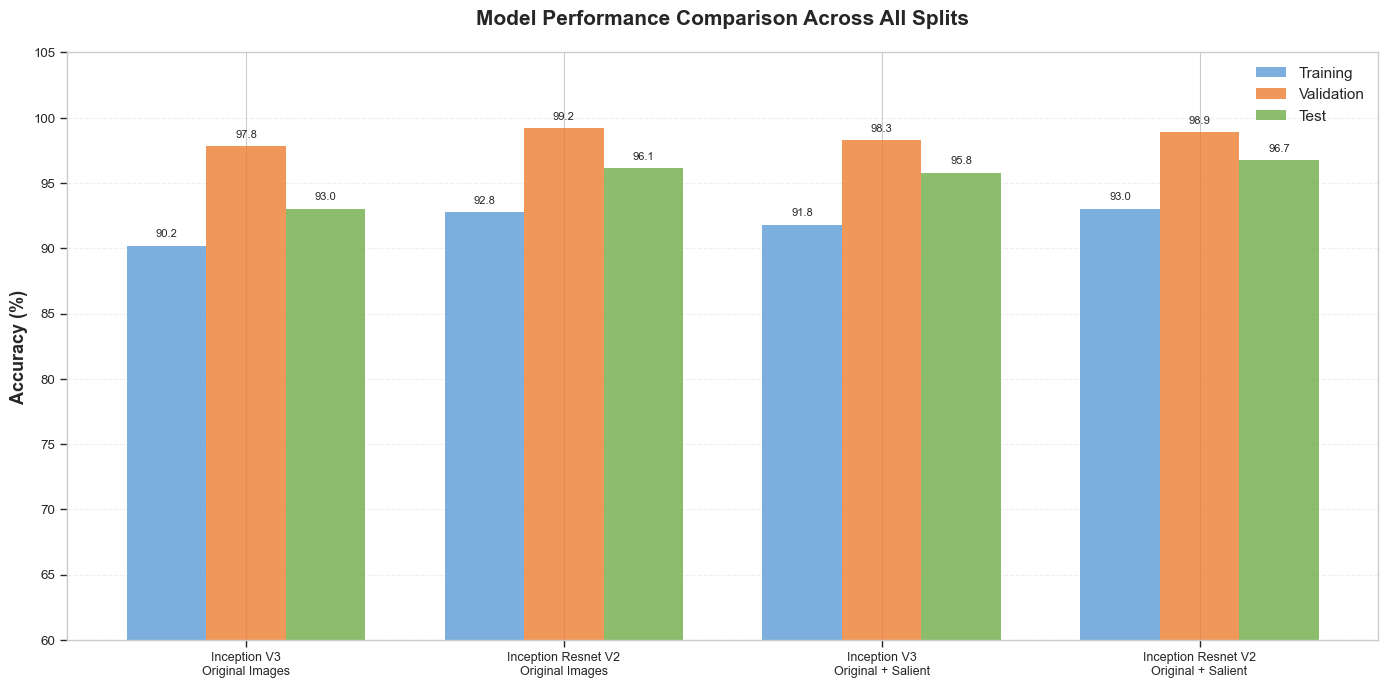




3️⃣ TRAINING HISTORY CURVES
--------------------------------------------------------------------------------


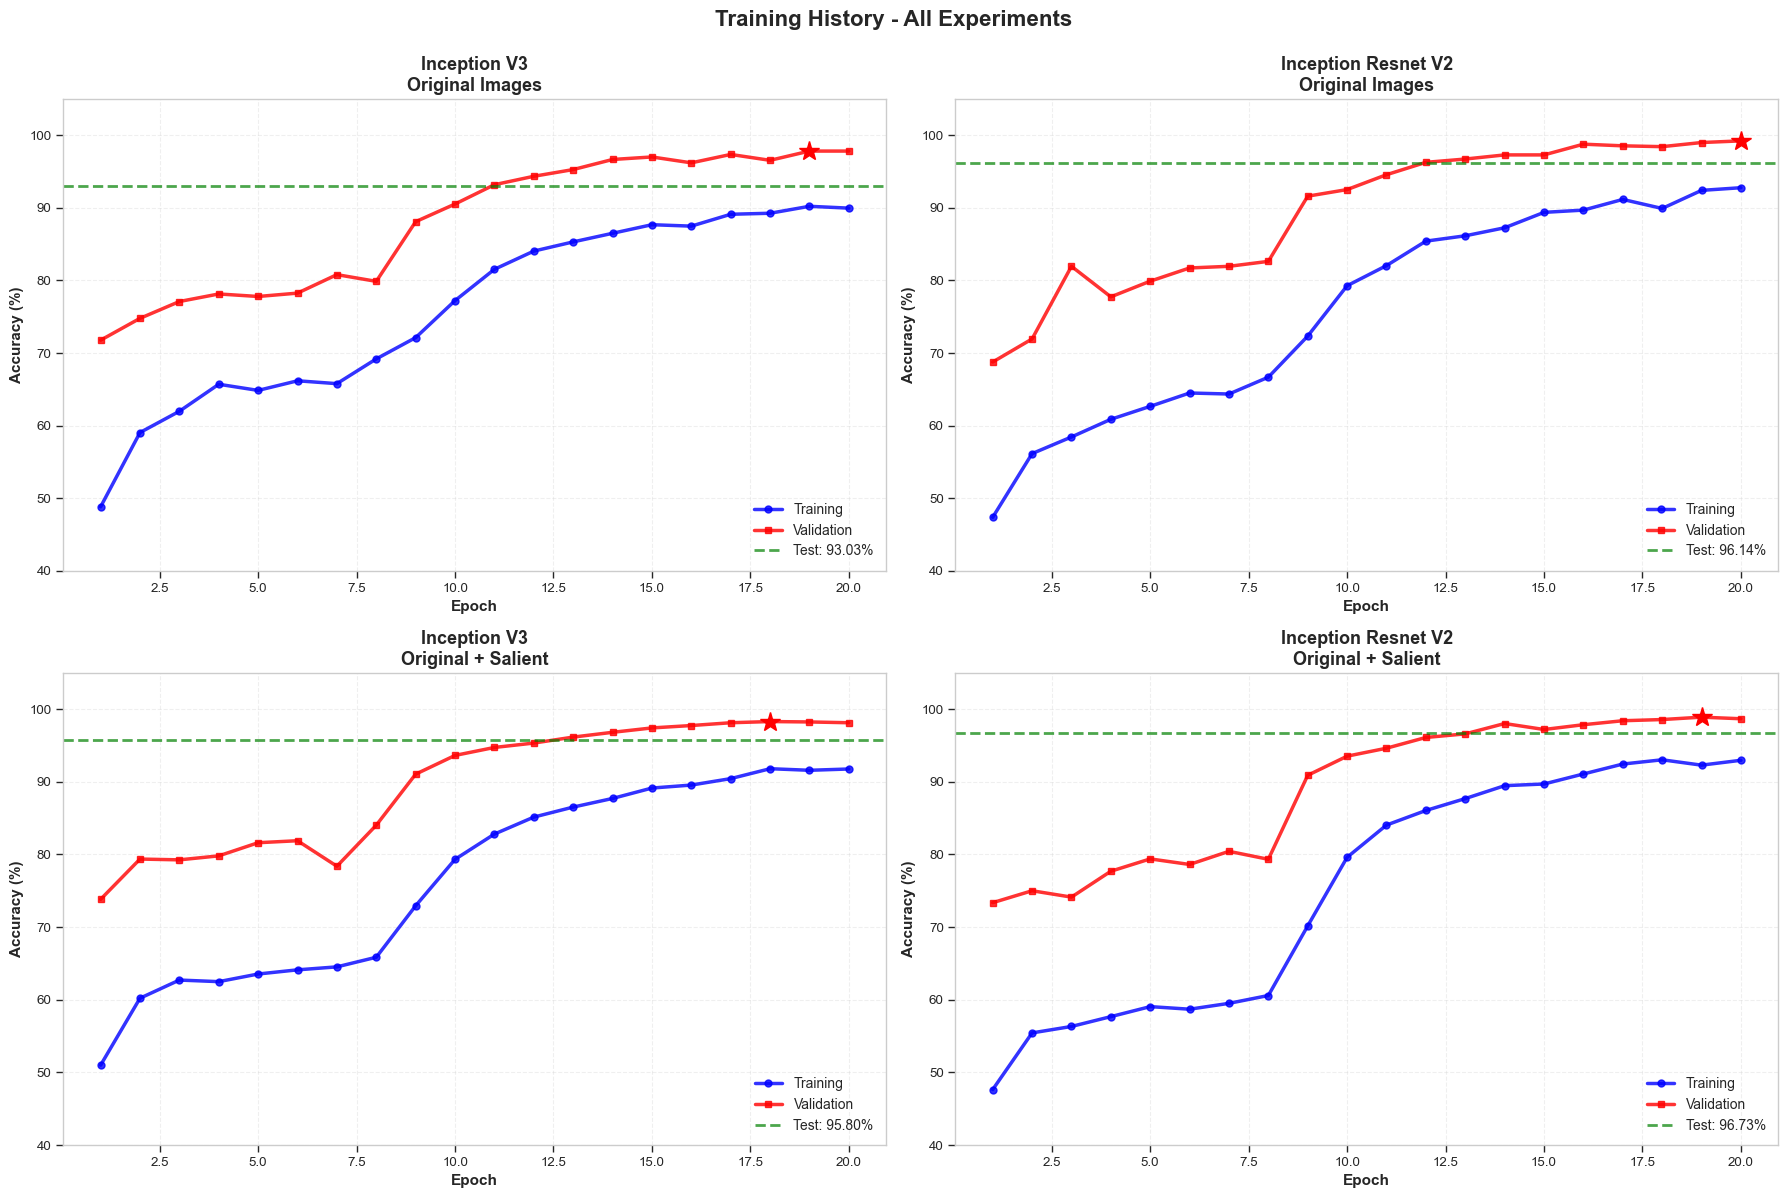




4️⃣ CONFUSION MATRICES
--------------------------------------------------------------------------------


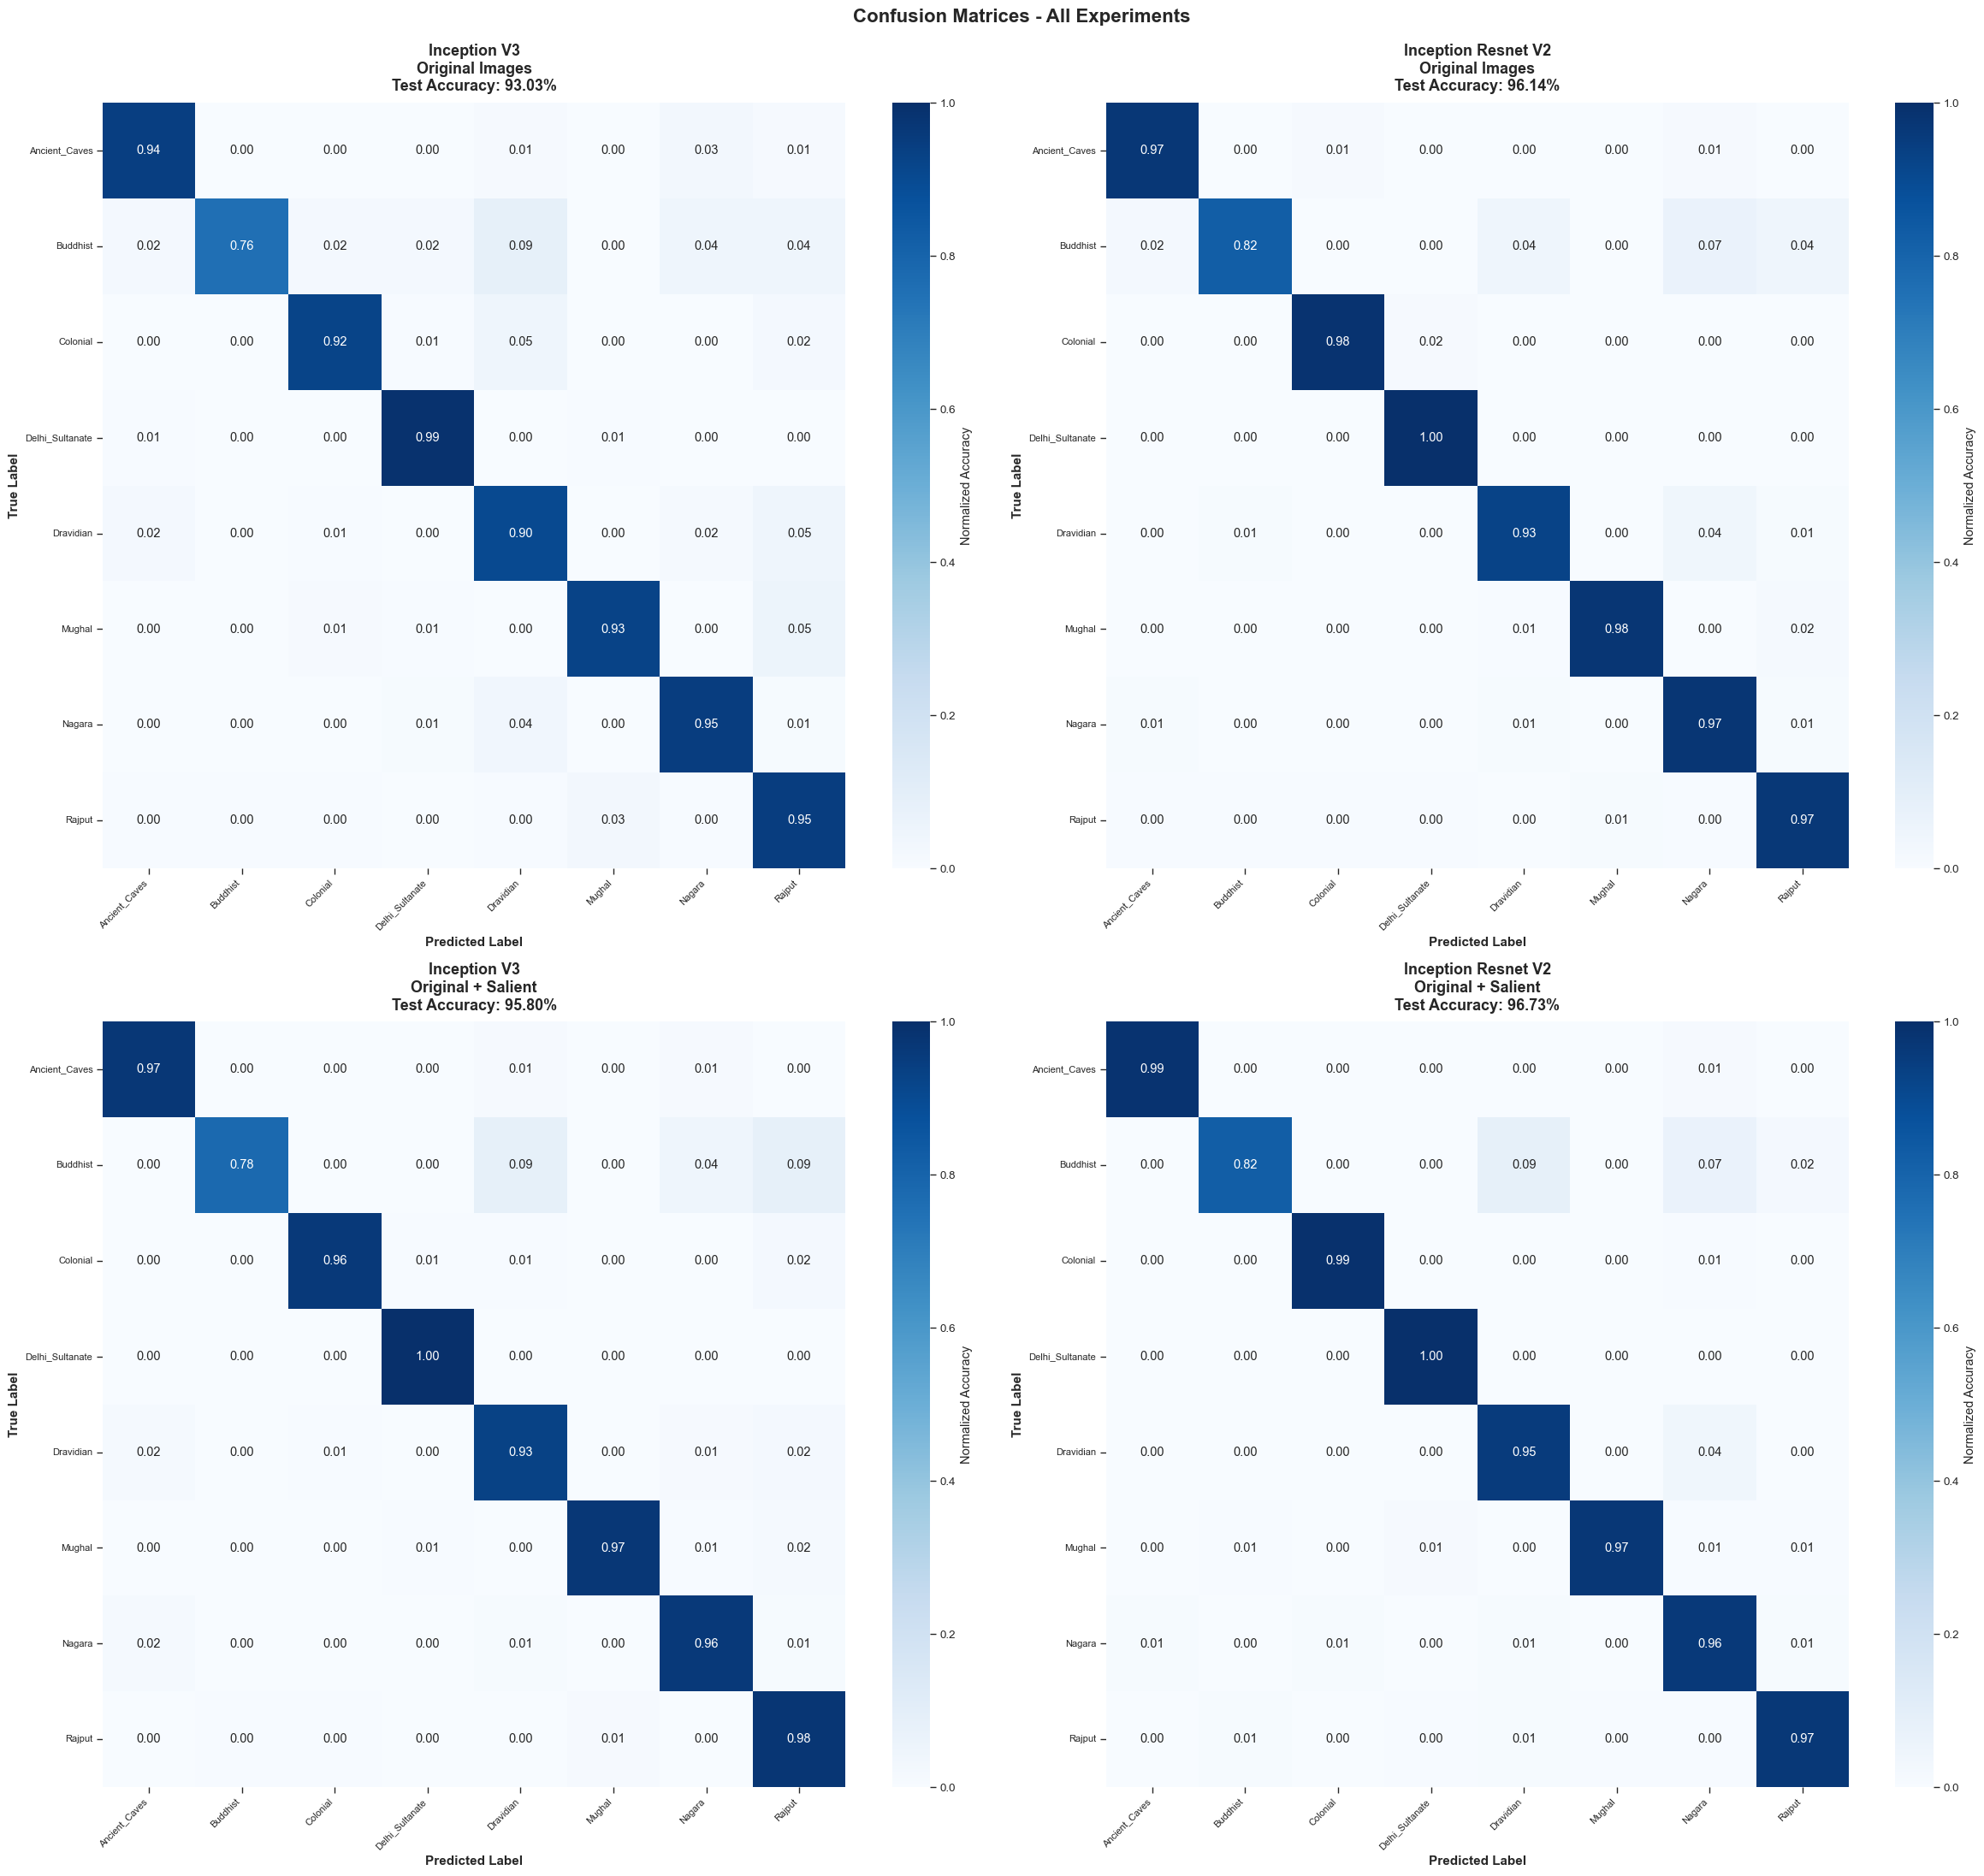




5️⃣ SALIENCY AUGMENTATION IMPACT
--------------------------------------------------------------------------------


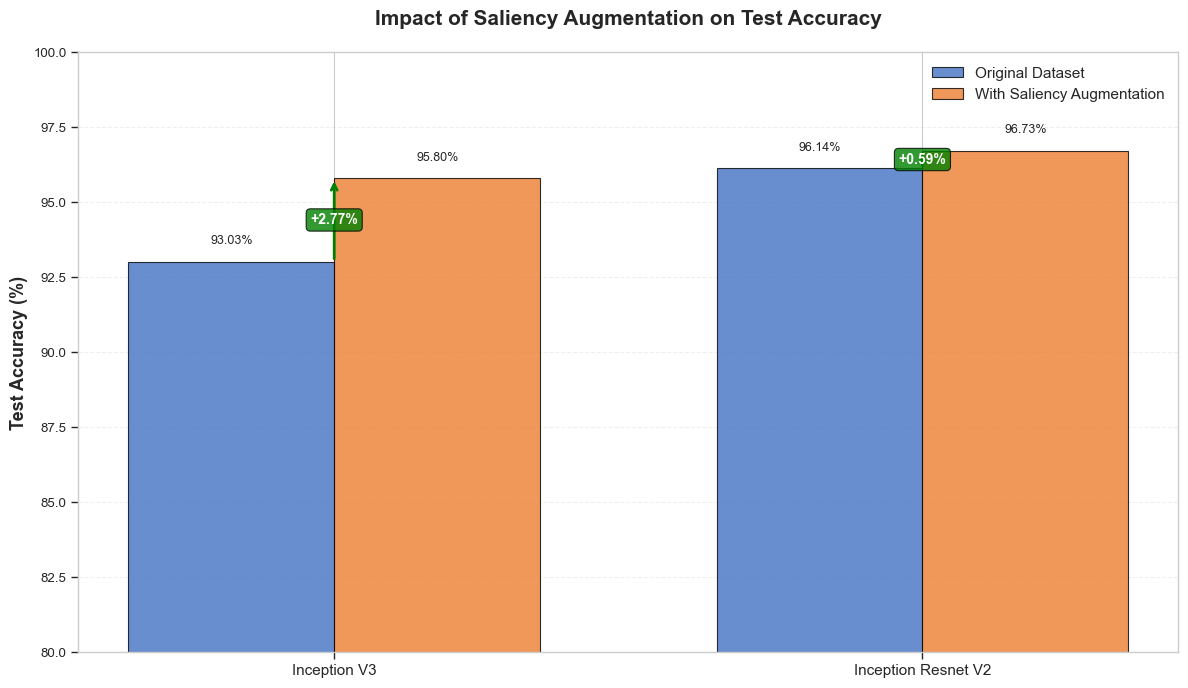



📈 IMPROVEMENT SUMMARY:

Inception V3:
  Original Dataset:     93.03%
  With Saliency:        95.80%
  Improvement:          +2.77%

Inception Resnet V2:
  Original Dataset:     96.14%
  With Saliency:        96.73%
  Improvement:          +0.59%



6️⃣ PER-CLASS ACCURACY (Best Model)
--------------------------------------------------------------------------------


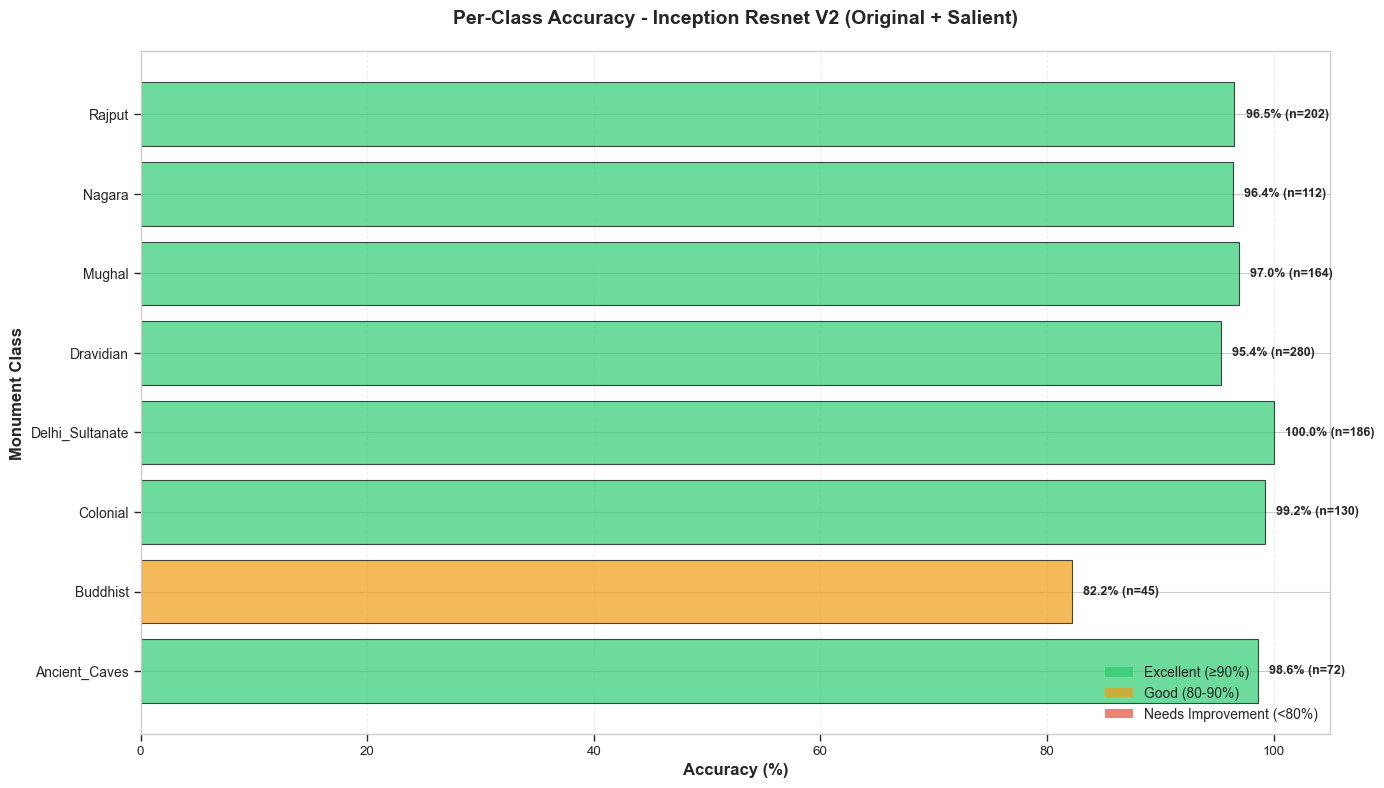




7️⃣ DETAILED CLASSIFICATION REPORTS
--------------------------------------------------------------------------------

EXPERIMENT 1: Inception V3 - Original Images

                 precision    recall  f1-score   support

  Ancient_Caves     0.8831    0.9444    0.9128        72
       Buddhist     0.9444    0.7556    0.8395        45
       Colonial     0.9524    0.9231    0.9375       130
Delhi_Sultanate     0.9787    0.9892    0.9840       186
      Dravidian     0.9405    0.9036    0.9217       280
         Mughal     0.9560    0.9268    0.9412       164
         Nagara     0.9138    0.9464    0.9298       112
         Rajput     0.8682    0.9455    0.9052       202

       accuracy                         0.9303      1191
      macro avg     0.9296    0.9168    0.9215      1191
   weighted avg     0.9318    0.9303    0.9301      1191


EXPERIMENT 2: Inception Resnet V2 - Original Images

                 precision    recall  f1-score   support

  Ancient_Caves     0.9589    0.97

In [21]:
# ===================================================
# INLINE RESULTS VISUALIZATION
# Display all results within notebook output
# ===================================================

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def display_results_inline(all_experiment_results):
    """
    Display comprehensive results with all visualizations inline
    """
    
    if not all_experiment_results:
        print("⚠️ No results to display")
        return
    
    # Set style for all plots
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.1)
    
    print("\n" + "="*80)
    print("📊 COMPREHENSIVE EXPERIMENT RESULTS")
    print("="*80 + "\n")
    
    # ============================================
    # 1. RESULTS COMPARISON TABLE
    # ============================================
    print("1️⃣ RESULTS COMPARISON TABLE")
    print("-"*80)
    
    results_df = pd.DataFrame({
        'Model': [r['Model Architecture'] for r in all_experiment_results],
        'Dataset': [r['Data Subset'] for r in all_experiment_results],
        'Train (%)': [f"{r['Train']:.2f}" for r in all_experiment_results],
        'Validation (%)': [f"{r['Validation']:.2f}" for r in all_experiment_results],
        'Test (%)': [f"{r['Test']:.2f}" for r in all_experiment_results]
    })
    
    # Display styled DataFrame
    display(results_df.style.set_properties(**{
        'text-align': 'center',
        'font-size': '11pt'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), 
                                      ('color', 'white'), 
                                      ('font-weight', 'bold'),
                                      ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]).highlight_max(subset=['Test (%)'], color='lightgreen'))
    
    print("\n")
    
    # Best model info
    best_idx = results_df['Test (%)'].astype(float).idxmax()
    best = all_experiment_results[best_idx]
    
    print("🏆 BEST PERFORMING MODEL")
    print("-"*80)
    print(f"Architecture:     {best['Model Architecture']}")
    print(f"Dataset:          {best['Data Subset']}")
    print(f"Train Accuracy:   {best['Train']:.2f}%")
    print(f"Val Accuracy:     {best['Validation']:.2f}%")
    print(f"Test Accuracy:    {best['Test']:.2f}%")
    print("-"*80 + "\n")
    
    # ============================================
    # 2. ACCURACY COMPARISON BAR CHART
    # ============================================
    print("\n2️⃣ ACCURACY COMPARISON")
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    models = [f"{r['Model Architecture']}\n{r['Data Subset']}" for r in all_experiment_results]
    train_accs = [r['Train'] for r in all_experiment_results]
    val_accs = [r['Validation'] for r in all_experiment_results]
    test_accs = [r['Test'] for r in all_experiment_results]
    
    x = np.arange(len(models))
    width = 0.25
    
    bars1 = ax.bar(x - width, train_accs, width, label='Training', color='#5B9BD5', alpha=0.8)
    bars2 = ax.bar(x, val_accs, width, label='Validation', color='#ED7D31', alpha=0.8)
    bars3 = ax.bar(x + width, test_accs, width, label='Test', color='#70AD47', alpha=0.8)
    
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Model Performance Comparison Across All Splits', fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([60, 105])
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    print("\n")
    
    # ============================================
    # 3. TRAINING CURVES (ALL MODELS)
    # ============================================
    print("\n3️⃣ TRAINING HISTORY CURVES")
    print("-"*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, result in enumerate(all_experiment_results):
        ax = axes[idx]
        history = result['history']
        epochs = range(1, len(history['train_acc']) + 1)
        
        # Convert to percentages
        train_acc_pct = [x * 100 for x in history['train_acc']]
        val_acc_pct = [x * 100 for x in history['val_acc']]
        
        # Plot with markers
        ax.plot(epochs, train_acc_pct, 'b-o', label='Training', 
               linewidth=2.5, markersize=5, alpha=0.8)
        ax.plot(epochs, val_acc_pct, 'r-s', label='Validation', 
               linewidth=2.5, markersize=5, alpha=0.8)
        
        # Add test accuracy horizontal line
        ax.axhline(y=result['Test'], color='green', linestyle='--', 
                  linewidth=2, label=f"Test: {result['Test']:.2f}%", alpha=0.7)
        
        ax.set_title(f"{result['Model Architecture']}\n{result['Data Subset']}", 
                    fontsize=13, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim([40, 105])
        
        # Highlight best validation epoch
        best_val_epoch = np.argmax(val_acc_pct)
        ax.plot(best_val_epoch + 1, val_acc_pct[best_val_epoch], 
               'r*', markersize=15, label='Best Val')
    
    plt.suptitle('Training History - All Experiments', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    print("\n")
    
    # ============================================
    # 4. CONFUSION MATRICES (ALL MODELS)
    # ============================================
    print("\n4️⃣ CONFUSION MATRICES")
    print("-"*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(24, 22))
    axes = axes.flatten()
    
    for idx, result in enumerate(all_experiment_results):
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        
        # Normalize for better visualization
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            ax=axes[idx],
            xticklabels=result['class_names'],
            yticklabels=result['class_names'],
            cbar_kws={'label': 'Normalized Accuracy'},
            vmin=0,
            vmax=1
        )
        
        title = (f"{result['Model Architecture']}\n"
                f"{result['Data Subset']}\n"
                f"Test Accuracy: {result['Test']:.2f}%")
        axes[idx].set_title(title, fontsize=13, fontweight='bold', pad=10)
        axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
        
        # Rotate labels for readability
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), 
                                  rotation=45, ha='right', fontsize=8)
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), 
                                  rotation=0, fontsize=8)
    
    plt.suptitle('Confusion Matrices - All Experiments', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    print("\n")
    
    # ============================================
    # 5. SALIENCY IMPACT ANALYSIS
    # ============================================
    print("\n5️⃣ SALIENCY AUGMENTATION IMPACT")
    print("-"*80)
    
    # Group by model to compare original vs combined
    models_dict = {}
    for r in all_experiment_results:
        model = r['Model Architecture']
        if model not in models_dict:
            models_dict[model] = {}
        
        if 'Salient' in r['Data Subset'] or 'Combined' in r['Data Subset']:
            models_dict[model]['combined'] = r['Test']
        else:
            models_dict[model]['original'] = r['Test']
    
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    model_names = list(models_dict.keys())
    original_accs = [models_dict[m].get('original', 0) for m in model_names]
    combined_accs = [models_dict[m].get('combined', 0) for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, original_accs, width, 
                  label='Original Dataset', color='#4472C4', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, combined_accs, width, 
                  label='With Saliency Augmentation', color='#ED7D31', alpha=0.8, edgecolor='black')
    
    ax.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Impact of Saliency Augmentation on Test Accuracy', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([80, 100])
    
    # Add improvement arrows and labels
    for i, (orig, comb) in enumerate(zip(original_accs, combined_accs)):
        if orig > 0 and comb > 0:
            improvement = comb - orig
            color = 'green' if improvement > 0 else 'red'
            
            # Arrow
            ax.annotate('', xy=(i, comb), xytext=(i, orig),
                       arrowprops=dict(arrowstyle='->', color=color, lw=2))
            
            # Label
            mid_y = (orig + comb) / 2
            ax.text(i, mid_y, f'{improvement:+.2f}%',
                   ha='center', va='center', fontsize=10, 
                   fontweight='bold', color='white',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{height:.2f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    print("\n")
    
    # Print numerical summary
    print("📈 IMPROVEMENT SUMMARY:")
    for model, accs in models_dict.items():
        if 'original' in accs and 'combined' in accs:
            improvement = accs['combined'] - accs['original']
            print(f"\n{model}:")
            print(f"  Original Dataset:     {accs['original']:.2f}%")
            print(f"  With Saliency:        {accs['combined']:.2f}%")
            print(f"  Improvement:          {improvement:+.2f}%")
    
    print("\n")
    
    # ============================================
    # 6. PER-CLASS ACCURACY (BEST MODEL)
    # ============================================
    print("\n6️⃣ PER-CLASS ACCURACY (Best Model)")
    print("-"*80)
    
    best_result = max(all_experiment_results, key=lambda x: x['Test'])
    
    # Calculate per-class accuracy
    class_accuracy = []
    class_support = []
    
    for i in range(len(best_result['class_names'])):
        mask = np.array(best_result['y_true']) == i
        support = mask.sum()
        class_support.append(support)
        
        if support > 0:
            correct = np.sum(np.array(best_result['y_pred'])[mask] == i)
            acc = (correct / support) * 100
            class_accuracy.append(acc)
        else:
            class_accuracy.append(0)
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(14, max(8, len(best_result['class_names']) * 0.4)))
    
    # Color code by accuracy
    colors = ['#2ECC71' if acc >= 90 else '#F39C12' if acc >= 80 else '#E74C3C' 
             for acc in class_accuracy]
    
    y_pos = np.arange(len(best_result['class_names']))
    bars = ax.barh(y_pos, class_accuracy, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(best_result['class_names'], fontsize=10)
    ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Monument Class', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class Accuracy - {best_result["Model Architecture"]} ({best_result["Data Subset"]})',
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_xlim([0, 105])
    
    # Add accuracy labels and support count
    for i, (bar, acc, support) in enumerate(zip(bars, class_accuracy, class_support)):
        label = f'{acc:.1f}% (n={support})'
        ax.text(acc + 1, i, label, va='center', fontsize=9, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ECC71', label='Excellent (≥90%)', alpha=0.7),
        Patch(facecolor='#F39C12', label='Good (80-90%)', alpha=0.7),
        Patch(facecolor='#E74C3C', label='Needs Improvement (<80%)', alpha=0.7)
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    print("\n")
    
    # ============================================
    # 7. CLASSIFICATION REPORTS
    # ============================================
    print("\n7️⃣ DETAILED CLASSIFICATION REPORTS")
    print("-"*80)
    
    for idx, result in enumerate(all_experiment_results, 1):
        print(f"\n{'='*80}")
        print(f"EXPERIMENT {idx}: {result['Model Architecture']} - {result['Data Subset']}")
        print(f"{'='*80}\n")
        
        report = classification_report(
            result['y_true'],
            result['y_pred'],
            target_names=result['class_names'],
            digits=4
        )
        print(report)
    
    # ============================================
    # FINAL SUMMARY
    # ============================================
    print("\n" + "="*80)
    print("📋 SUMMARY")
    print("="*80)
    print(f"Total Experiments:     {len(all_experiment_results)}")
    print(f"Best Test Accuracy:    {max(r['Test'] for r in all_experiment_results):.2f}%")
    print(f"Best Model:            {best_result['Model Architecture']}")
    print(f"Best Dataset:          {best_result['Data Subset']}")
    print("="*80 + "\n")

# ===================================================
# DISPLAY ALL RESULTS
# ===================================================
print("\n" + "="*80)
print("DISPLAYING RESULTS...")
print("="*80 + "\n")

# Call the visualization function
display_results_inline(all_experiment_results)